In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
%matplotlib inline

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
## !pip install git+https://github.com/JoaquinAmatRodrigo/skforecast@v0.1.8.1

In [3]:
# Modelado y Forecasting
# ==============================================================================


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterCustom import ForecasterCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import time_series_spliter
from skforecast.model_selection import cv_forecaster
from skforecast.model_selection import backtesting_forecaster_intervals

In [4]:
# Descarga de datos
# ==============================================================================
url = 'hoja.xlsx'
datos = pd.read_excel(url)

In [5]:
datos.head()

,Fecha,Hora,ValorVentas,Dia,Toque,HoraDeInicio
0,2021-04-01,07:00:00,0.0,Jueves,no,00:00:00
1,2021-04-01,08:00:00,19700.0,Jueves,no,00:00:00
2,2021-04-01,09:00:00,33500.0,Jueves,no,00:00:00
3,2021-04-01,10:00:00,16500.0,Jueves,no,00:00:00
4,2021-04-01,11:00:00,25500.0,Jueves,no,00:00:00


In [6]:
datos.tail()

,Fecha,Hora,ValorVentas,Dia,Toque,HoraDeInicio
454,2021-04-22,NaN,NaN,NaN,NaN,NaN
455,2021-04-22,NaN,NaN,NaN,NaN,NaN
456,2021-04-22,NaN,NaN,NaN,NaN,NaN
457,2021-04-22,NaN,NaN,NaN,NaN,NaN
458,2021-04-22,NaN,NaN,NaN,NaN,NaN


In [7]:
datos.keys()

Index(['Fecha', 'Hora', 'ValorVentas', 'Dia', 'Toque', 'HoraDeInicio'], dtype='object')

In [8]:
datos['Fecha'] 

0     2021-04-01
1     2021-04-01
2     2021-04-01
3     2021-04-01
4     2021-04-01
         ...    
454   2021-04-22
455   2021-04-22
456   2021-04-22
457   2021-04-22
458   2021-04-22
Name: Fecha, Length: 459, dtype: datetime64[ns]

In [9]:
# Esta no va por si acaso 
# for fecha in ['Fecha']:
#    datos[fecha]= pd.to_datetime(datos[fecha], format="%Y-%m-%d")

In [10]:
datos.head()

,Fecha,Hora,ValorVentas,Dia,Toque,HoraDeInicio
0,2021-04-01,07:00:00,0.0,Jueves,no,00:00:00
1,2021-04-01,08:00:00,19700.0,Jueves,no,00:00:00
2,2021-04-01,09:00:00,33500.0,Jueves,no,00:00:00
3,2021-04-01,10:00:00,16500.0,Jueves,no,00:00:00
4,2021-04-01,11:00:00,25500.0,Jueves,no,00:00:00


In [11]:
# Preparación del dato
# ==============================================================================
datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d')
datos = datos.set_index('Fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('MS')
datos = datos['y']
datos = datos.sort_index()

In [12]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

ValueError: Lengths must match

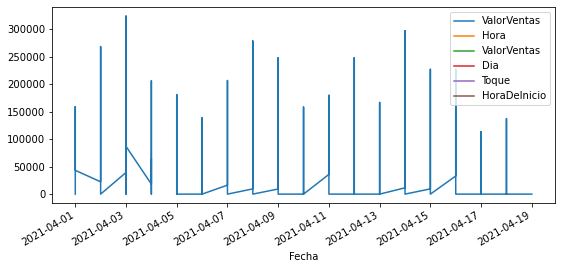

In [13]:
# Separación datos train-test
# ==============================================================================
steps = 50
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend();

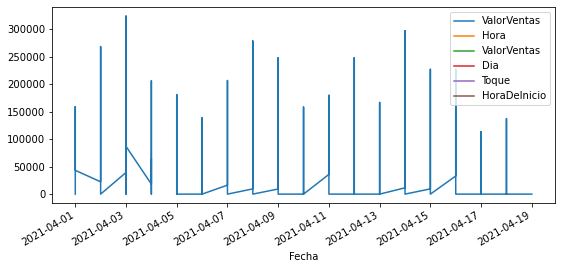

In [14]:
# Separación datos train-test
steps = 12
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

fig, ax=plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend();

In [26]:
# Estimacion 1

steps = 12
estimación = forecaster_rf.predict(steps=steps)
estimación = pd.Series(data=predicciones, index=datos_test.index)
estimación.head()

NameError: name 'predicciones' is not defined

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
estimación.plot(ax=ax, label='estimación')
ax.legend();

In [ ]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

In [ ]:
forecaster_rf = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags      = 12 # Este valor será remplazado en el grid search
                 )

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}


lags_grid = [10, 20]

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster_rf,
                        y           = datos_train,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 10,
                        method      = 'cv',
                        metric      = 'neg_mean_squared_error',
                        initial_train_size    = int(len(datos_train)*0.5),
                        allow_incomplete_fold = False,
                        return_best = True,
                        verbose     = False
                   )

In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=10, n_estimators=500, random_state=123)

forecaster_rf = ForecasterAutoreg(
                    regressor = regressor,
                    lags      = 20
                )

forecaster_rf.fit(y=datos_train)

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster_rf.predict(steps=steps)
# Se añade el índice a las predicciones
predicciones = pd.Series(data=predicciones, index=datos_test.index)

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test,
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")

In [ ]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster_rf.get_feature_importances()
dict(zip(forecaster_rf.lags, impotancia))

In [ ]:
# Modelo autorregresivo lineal statsmodels
# ==============================================================================
from statsmodels.tsa.ar_model import AutoReg
lags = 15

modelo_ar = AutoReg(datos_train, lags=lags)
res = modelo_ar.fit()
predicciones_statsmodels = res.predict(start=datos_test.index[0], end=datos_test.index[-1])

# Modelo autorregresivo lineal Forecaster
# ==============================================================================
regressor = LinearRegression()
forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)
forecaster.fit(y=datos_train)
predicciones_forecaster = forecaster.predict(steps=36)

# Verificación de que las predicciones de ambos modelos son iguales
# ==============================================================================
print(np.allclose(predicciones_statsmodels.values, predicciones_forecaster))

# Verificación de que los coeficients de ambos modelos son iguales
# ==============================================================================
print(np.allclose(res.params.values[1:], forecaster.get_coef()))